# Fine Food Review

Ludovic Herbelin, 2020

**Goals : Predict review score from the text of the review.**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import numpy as np
from tqdm.notebook import tqdm
import sklearn

## Loading data

In [2]:
DATASET_PATH = 'Reviews.csv'
N_ROWS = 60000

dataset = pd.read_csv(DATASET_PATH, nrows=N_ROWS)

print(f"{len(dataset)} rows in data")

60000 rows in data


In [3]:
df = dataset.copy()
df = df.drop(columns=['Id','ProductId', 'UserId', 'ProfileName', 'Time', 'Text'])
feature_column = 'Summary'

df.dropna(inplace=True)
df.head()

,HelpfulnessNumerator,HelpfulnessDenominator,Score,Summary
0,1,1,5,Good Quality Dog Food
1,0,0,1,Not as Advertised
2,1,1,4,"""Delight"" says it all"
3,3,3,2,Cough Medicine
4,0,0,5,Great taffy


### Remove the neutral reviews

In [4]:
# depending on our goals we might want to remove neutral reviews (IE score of 3)
REMOVE_NEUTRAL = False

if REMOVE_NEUTRAL:
    df = df[df.Score != 3]
    print(f"{len(df)} rows left")

### Remove reviews below certain threshold

In [5]:
HELPFULNESS_THRESH_RATIO = 2

# numerator of helpfulness score must be higher or equal than X times denominator
df = df[df.HelpfulnessNumerator * HELPFULNESS_THRESH_RATIO >= df.HelpfulnessDenominator]
print(f"{len(df)} rows left")

54713 rows left


### Plot class distribution

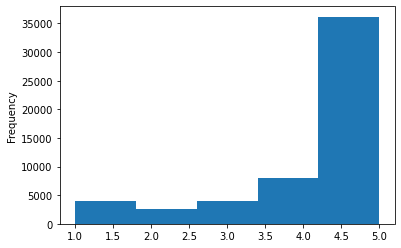

In [6]:
ax = df['Score'].plot.hist(bins=5)

## Dataset preprocessing

In [7]:
X = df.loc[:, df.columns != 'Score']
Y = df['Score']

In [8]:
from sklearn.model_selection import train_test_split
TRAIN_RATIO = 0.8

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, stratify=Y, train_size=TRAIN_RATIO, random_state=42)

print(f"Train size : {len(Y_train)}, test set size : {len(Y_test)}")

Train size : 43770, test set size : 10943


### Text preprocessing

Helper class for preprocessing the text : remove stopwords, punctuation etc.

In [9]:
from nltk.stem import SnowballStemmer 
from nltk.tokenize import word_tokenize 
from nltk.corpus import stopwords


class TextProcessor:
    def __init__(self, language='english', remove_stopwords = True, perform_stemming = True):
        """ init functions, load the stopwords and punkt for tokenizer
        Keywords args :
        language -- 'english' or other
        remove_stopwords -- If true, will perform stopwords removal
        perform_stemming -- If true, will stem the words
        """
        nltk.download('stopwords')
        nltk.download('punkt')
        self.perform_stemming = perform_stemming
        if(self.perform_stemming):
            self.stemmer = SnowballStemmer(language)
        self.remove_stopwords = remove_stopwords
        if(self.remove_stopwords):
            self.stopwords = set(stopwords.words(language))  

    def __stem_word__(self, word):
        return self.stemmer.stem(word)

    def __tokenize_text__(self, text):
        return word_tokenize(text)


    def preprocess_text(self, text):
        """Set the words in the text to lowercase, remove the stop words and punctuation if set to true at init"""
        words = self.__tokenize_text__(text)
        
        # set words to lowercase and remove punctuation
        words = [word.lower() for word in words if word.isalpha()]
        if self.perform_stemming:
            words = [self.__stem_word__(word) for word in words]
        if self.remove_stopwords:
            words = list(filter(lambda w: w not in self.stopwords, words))
        
        return ' '.join(words)

tp = TextProcessor(remove_stopwords=True, perform_stemming=True)
print(tp.preprocess_text(df[feature_column][0]))

good qualiti dog food


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ludovic\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Ludovic\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Preparing data for training the models

In [10]:
feature_column_cleanup = feature_column + '_cleanup'
# apply preprocessing operations on the text
def prepare_text(data, feature_column):
    data.loc[:, [feature_column_cleanup]] = data[feature_column].apply(tp.preprocess_text)
    return data
    

X_train = prepare_text(X_train, feature_column)
X_test = prepare_text(X_test, feature_column)

feature_column = feature_column_cleanup

e:\documents\school\swisscom_assignment\finefoodreview\venv\lib\site-packages\pandas\core\indexing.py:659: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[k] = np.nan
e:\documents\school\swisscom_assignment\finefoodreview\venv\lib\site-packages\pandas\core\indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


### Transform textual data to TFIDF

In [11]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

# bag of words + tfidf on text
vectorizer = CountVectorizer()
transformer = TfidfTransformer()

X_train_counts = vectorizer.fit_transform(X_train[feature_column_cleanup])
X_train_tfidf = transformer.fit_transform(X_train_counts)

X_test_counts = vectorizer.transform(X_test[feature_column_cleanup])
X_test_tfidf = transformer.transform(X_test_counts)

print(X_train_tfidf.shape)
print(X_test_tfidf.shape)

(43770, 7309)
(10943, 7309)


## Classification

### Grid search

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

In [13]:
from sklearn.model_selection import GridSearchCV

COMPUTE_GRID_SEARCH = True

if COMPUTE_GRID_SEARCH:
    parameters = {'max_iter':[1e6], 'penalty': ('l1', 'l2'), 'C': [1e-5, 1e-3, 1.0]}
    lr = LogisticRegression()
    
    clf = GridSearchCV(lr, parameters, n_jobs=6)
    clf.fit(X_train_tfidf, Y_train)

    print('Best Score: %s' % clf.best_score_)
    print('Best Hyperparameters: %s' % clf.best_params_)

Best Score: 0.7050491204021019
Best Hyperparameters: {'C': 1.0, 'max_iter': 1000000.0, 'penalty': 'l2'}


### Models definition

In [14]:
models_dict = {
    'LogisticRegression': LogisticRegression(max_iter=100000, C=1.0, penalty='l2'),
    'RandomForest': RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    'MultinomialNB': MultinomialNB(),
    'SVC':LinearSVC()
}

### Metrics

In [15]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

def compute_metrics(model, X, Y):
    metrics_dict = {}
    y_pred = model.predict(X)
    metrics_dict['f1'] = f1_score(Y, y_pred, average='macro')
    metrics_dict['accuracy'] = accuracy_score(Y, y_pred)
    
    return metrics_dict

In [16]:
models_results = {}

for label, model in models_dict.items():
    # fit and test the model
    model.fit(X_train_tfidf, Y_train)
    models_results[label] = compute_metrics(model, X_test_tfidf, Y_test)
    
print(models_results)

{'LogisticRegression': {'f1': 0.3850247568087421, 'accuracy': 0.7056565841177008}, 'RandomForest': {'f1': 0.1592034327208714, 'accuracy': 0.6611532486521063}, 'MultinomialNB': {'f1': 0.3116031242136629, 'accuracy': 0.6953303481677785}, 'SVC': {'f1': 0.39050214723999926, 'accuracy': 0.6978890615005026}}


### Plot metrics

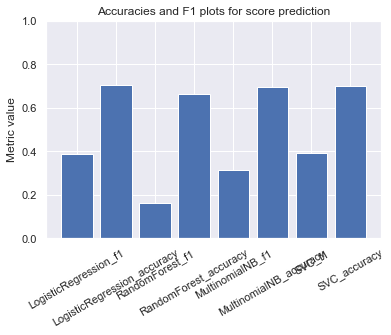

In [17]:
sns.set_theme()

def plot_bar(results_dict, title, ylabel):
    plt.bar(results_dict.keys(), results_dict.values())
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xticks(rotation=30)
    plt.ylim((0,1))
    plt.show()

metrics_dict = {}

for label, results in models_results.items():
    for metric, val in results.items():
        metrics_dict[f"{label}_{metric}"] = val
        
plot_bar(metrics_dict, "Accuracies and F1 plots for score prediction", "Metric value")

### Print the most important words for each score

In [18]:
TOP_N_WORDS = 10

def get_top_words_score(clf, TOP_N):
    feature_names = vectorizer.get_feature_names()
    top_words = {}
    for i, score in enumerate(set(Y_test)):
        # get the TOP_N sorted (desc) by their coefficient of importance in the classifier
        top = np.argsort(clf.coef_[i])[-TOP_N_WORDS:]
        top_words[score] = list(feature_names[word_id] for word_id in top)
        
    return top_words

top_words = get_top_words_score(models_dict['LogisticRegression'], TOP_N = TOP_N_WORDS)
for score, words in top_words.items():
    print(f"[Score = {score}] : {words}")

[Score = 1] : ['ruin', 'china', 'rip', 'terribl', 'nasti', 'yuck', 'worst', 'disgust', 'horribl', 'aw']
[Score = 2] : ['togeth', 'blah', 'eh', 'bland', 'weak', 'kettl', 'wo', 'poor', 'meh', 'disappoint']
[Score = 3] : ['mild', 'meh', 'alright', 'iffi', 'decent', 'unremark', 'short', 'averag', 'okay', 'ok']
[Score = 4] : ['good', 'love', 'refresh', 'excel', 'pretti', 'great', 'delici', 'nice', 'tasti', 'yummi']
[Score = 5] : ['fantast', 'wonder', 'amaz', 'awesom', 'love', 'delici', 'perfect', 'great', 'best', 'excel']
